Importing libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

Reading Data and Basic operations of nltk

In [109]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
#taking small portion of dataset
a=int(input("Enter the number of data from the dataset to compute sentiments:"))
df = df.head(a)
print(df.shape)

(568454, 10)
(150, 10)


In [110]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


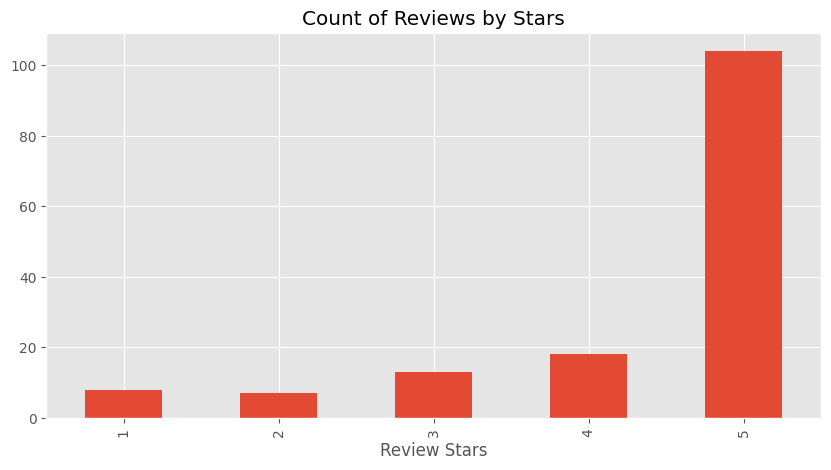

In [111]:
#ploting a bar graph to check the distribution of stars in the review
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [112]:
#taking sample for check working is correct or not
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [113]:
#convert the complete statement into a tokens (step known as tokenization)
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

VADER Model

In [114]:
#importing Sentiment Intensity analyser from the nltk to use VADER 
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sentiment_intensity_analysis = SentimentIntensityAnalyzer()

In [115]:
# checking sentiments on sample before running on complete dataset
sentiment_intensity_analysis.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [116]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    vader_result = sentiment_intensity_analysis.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    res[myid] = vader_result_rename

  0%|          | 0/150 [00:00<?, ?it/s]

In [117]:
# Merging the vader model result to dataset
vaders_model_df = pd.DataFrame(res).T
vaders_model_df = vaders_model_df.reset_index().rename(columns={'index': 'Id'})
vaders_model_df = vaders_model_df.merge(df, how='left')

In [118]:
vaders_model_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


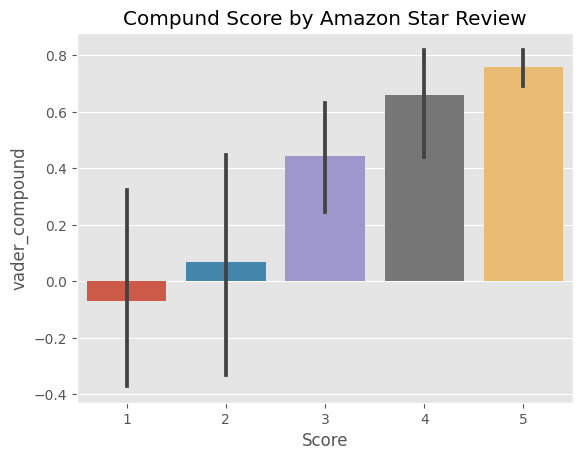

In [119]:
#ploting graph between score and compound to check the polarity distribution over a score 
ax = sns.barplot(data=vaders_model_df, x='Score', y='vader_compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

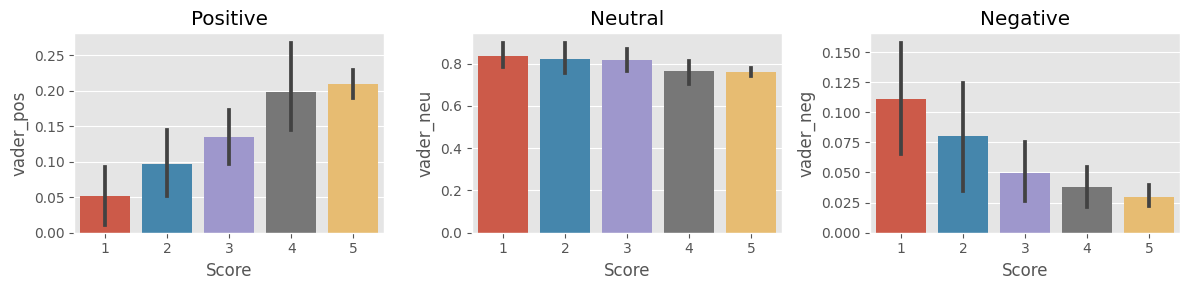

In [120]:
#ploting graph to check distribution of score over positive, negative and neutral polarity
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders_model_df, x='Score', y='vader_pos', ax=axs[0])
sns.barplot(data=vaders_model_df, x='Score', y='vader_neu', ax=axs[1])
sns.barplot(data=vaders_model_df, x='Score', y='vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Roberta Model(Hugging face model)

In [121]:
#importing libraries to run roberta model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [122]:
#train the model with the help of preperformed python sentiment analysis of twitter 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
#tokenizing the Model using autotokenizer and sequencing the pretrained mmodel
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [123]:
# Run for Roberta Model on sample case
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
#print(output)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.0029573706}


In [124]:
#function for the Roberta model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [125]:
#running vader and roberta model for sentiment
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/150 [00:00<?, ?it/s]

Broke for id 83


In [126]:
#merging both model result in dataset
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(vaders_model_df, how='left')

In [127]:
results_df.columns
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Combing and Comparing

C:\Users\lkban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


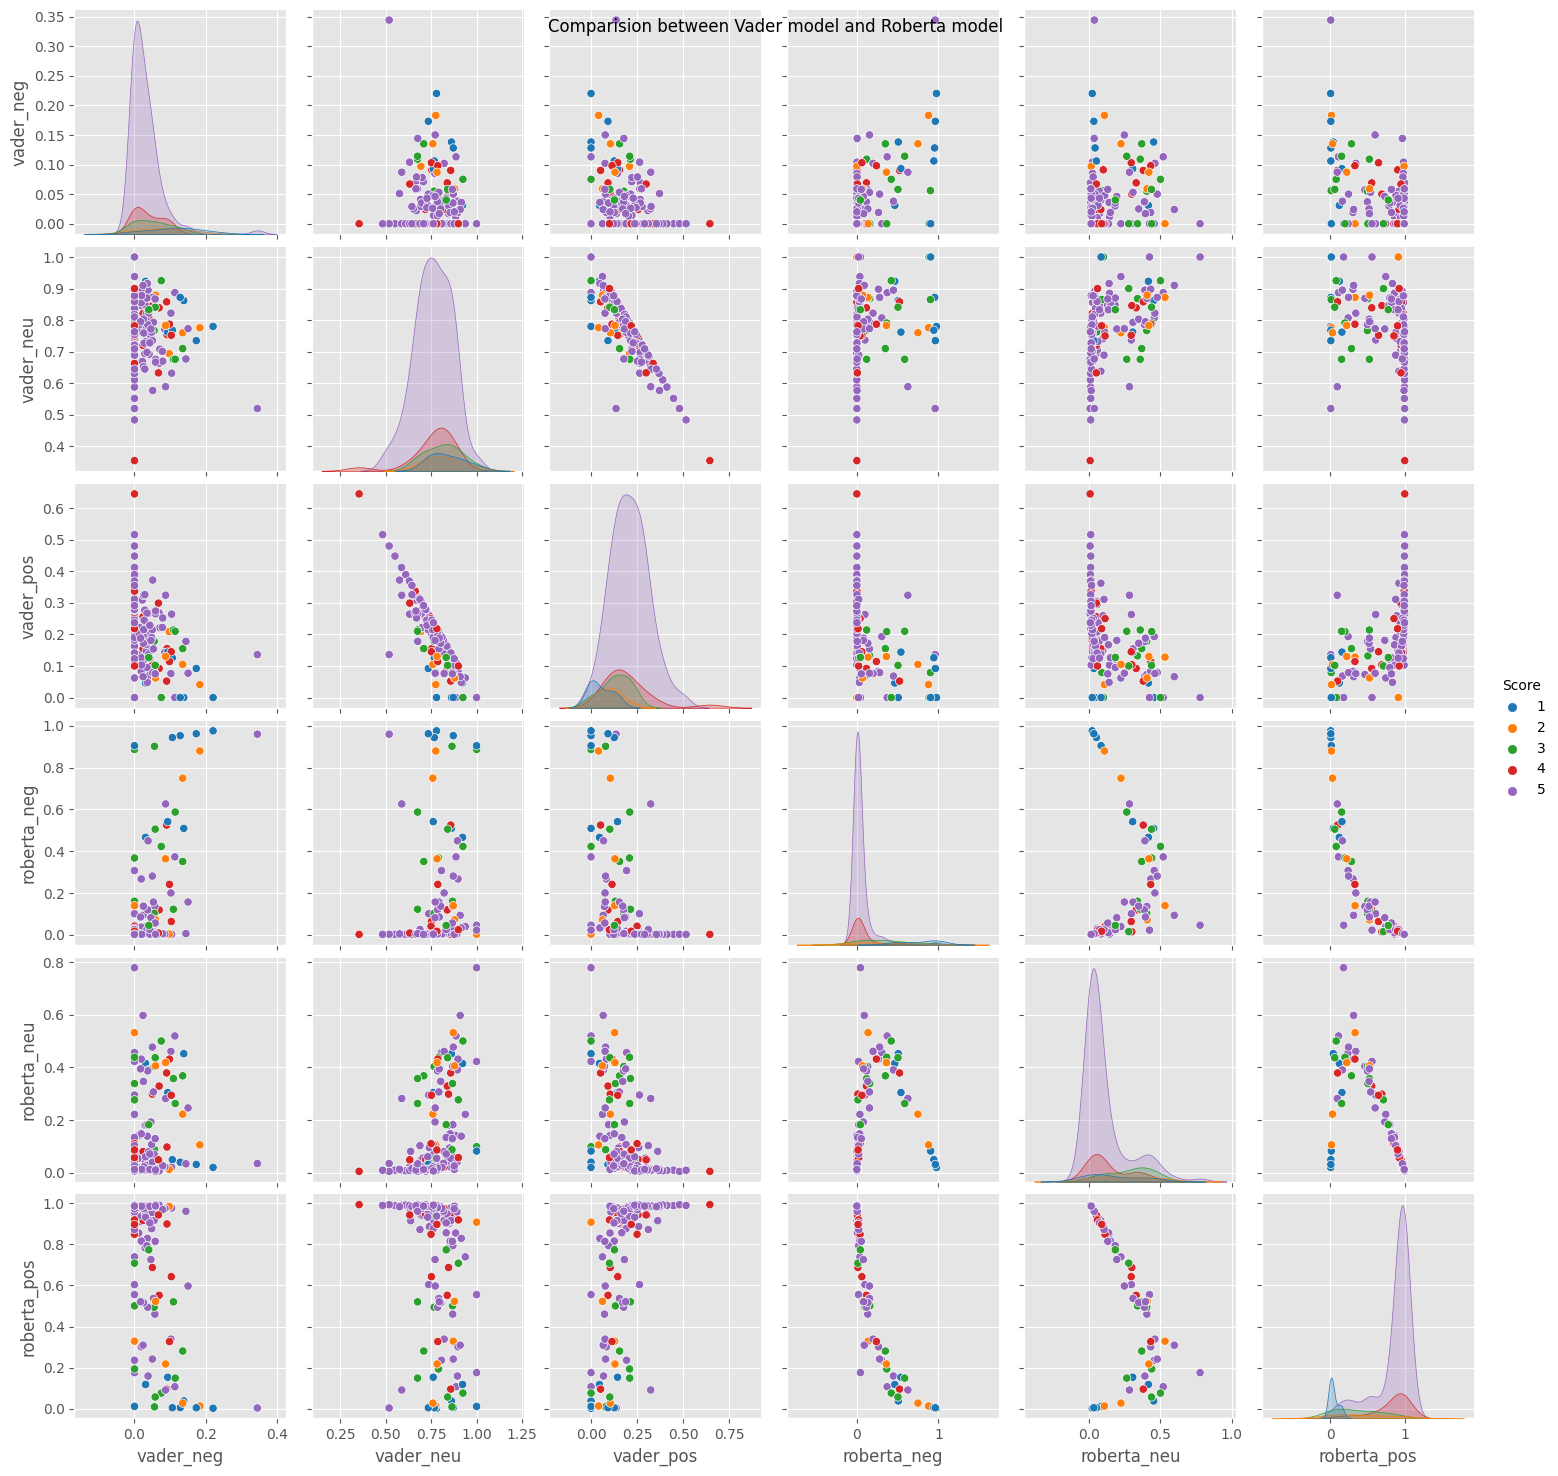

In [128]:
a=sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
a.fig.suptitle("Comparision between Vader model and Roberta model")
plt.show()

Pipelining Model(Faster and easier model)

In [129]:
#importing pipeline from transformers
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [130]:
#checking pipeline result on sample case
sentiment_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.9994776844978333}]

In [131]:
#pipeline model on entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        pipeline = sentiment_pipeline(text)
        pipeline_rename = {}
        for key, value in pipeline:
            pipeline_rename[f"feedback"] = pipeline[0][key]
        res[myid] = pipeline_rename
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/150 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


Broke for id 83


In [132]:
#merging result with previous df
final_results = pd.DataFrame(res).T
final_results = final_results.reset_index().rename(columns={'index': 'Id'})
final_results = final_results.merge(results_df, how='left')
final_results.head(100)

,Id,feedback,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,POSITIVE,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,NEGATIVE,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,POSITIVE,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,POSITIVE,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,POSITIVE,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,POSITIVE,0.003077,0.036150,0.960772,0.000,0.818,0.182,0.9820,B0019CW0HE,A18AAABCIJKC5Q,Rhiever,0,0,5,1303776000,Great dog food,My 1-1/2 year old basenji/jack russell mix lov...
96,98,POSITIVE,0.156117,0.307076,0.536807,0.053,0.793,0.154,0.7729,B0019CW0HE,A3UII2114114PI,"FuNky Faja ""SiLkk""",0,0,5,1297296000,"Great allergy sensitive dog food, dogs love it",Our pup has experienced allergies in forms of ...
97,99,NEGATIVE,0.092719,0.597661,0.309620,0.024,0.910,0.066,0.5106,B0019CW0HE,ABZ9F0D94YK45,Amazon-tron 3000,0,0,5,1295308800,Perfect for our English Bulldog with Allergies,My English Bulldog had skin allergies the summ...
98,100,NEGATIVE,0.962443,0.031979,0.005579,0.173,0.735,0.092,-0.5267,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...


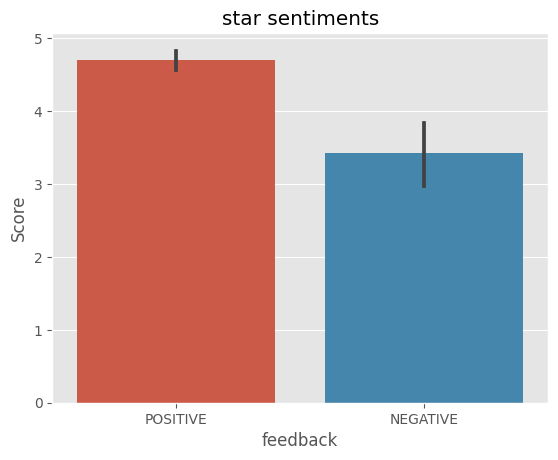

In [133]:
#graph positive and score
a=sns.barplot(data=final_results, y='Score', x='feedback')
a.set_title("star sentiments")
plt.show()

Giving the final feedback file.

In [134]:
import os
final_results.to_csv("smart_feedback.csv",index=False)
print("Feedback file is created:",os.path.abspath("smart_feedback.csv"))

Feedback file is created: d:\mini_project\IV_sem\smart_feedback.csv
